In [149]:
import numpy as np
import serpentTools as st
from snapReactors.reactor_models.AutomatedSerpentModels.GCU.c3_radial_sens_2d.utilitities import*
import os
from numpy.linalg import norm
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 13}
#label = {"axes.labelweight"}

matplotlib.rc('font', **font)
plt.rcParams["axes.labelweight"] = "bold"

In [150]:
ringresFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_1.main_res.m'
ringres = st.read(ringresFile, reader='results')

SERPENT Serpent 2.2.1 found in /Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_1.main_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


### System Analysis

In [93]:
# coreUni = ringres.universes['100', 0, 0, 0]
rootUni = ringres.universes['0', 0, 0, 0]

In [94]:
# rootUni.infExp.keys()

In [95]:
# ax = rootUni.plot('infTot', labels=['infAbs - system'])
# ax.grid()
# coreUni.plot('infTot', ax=ax, labels = ['infAbs - core'], legend='right')

In [96]:
def condense(universe, key, useInvFlux = False):
    cond = None
    if useInvFlux:
        invFlux = np.zeros(len(universe.infExp[key]))
        for i in range(0, len(invFlux)):
            invFlux[i] = 1/universe.infExp[key][i]
        cond = np.sum(np.multiply(universe.infExp[key], invFlux)/np.sum(invFlux))
    else:
        cond = np.sum(np.multiply(universe.infExp[key], universe.infExp['infFlx']))/np.sum(universe.infExp['infFlx'])
    return cond

In [97]:
fluxweight_coreTranspxs = condense(rootUni, 'infTranspxs')
invfluxweight_coreTranspxs = condense(rootUni, 'infTranspxs', useInvFlux=True)

fluxweight_coreDiff = 1/(3*fluxweight_coreTranspxs)
invfluxweight_coreDiff = 1/(3*invfluxweight_coreTranspxs)

print("fluxweighted infTranspxs : {:.3f}".format(fluxweight_coreTranspxs))
print("invfluxweighted infTranspxs mfp : {:.3f}".format(1/invfluxweight_coreTranspxs))

print("fluxweighted infDiff : {:.3f}".format(fluxweight_coreDiff))
print("invfluxweighted infDiff : {:.3f}".format(invfluxweight_coreDiff))

coreAbs = condense(rootUni, 'infAbs')

fluxweight_coreDiffLen = np.sqrt(fluxweight_coreDiff/coreAbs)
invfluxweight_coreDiffLen = np.sqrt(invfluxweight_coreDiff/coreAbs)

print("fluxweighted infAbs mfp : {:.3f}".format(1/coreAbs))

print("fluxweighted infDiffLen : {:.3f}".format(fluxweight_coreDiffLen))
print("invfluxweighted infDiffLen : {:.3f}".format(invfluxweight_coreDiffLen))  

fluxweighted infTranspxs : 0.444
invfluxweighted infTranspxs mfp : 3.059
fluxweighted infDiff : 0.750
invfluxweighted infDiff : 1.020
fluxweighted infAbs mfp : 49.968
fluxweighted infDiffLen : 6.123
invfluxweighted infDiffLen : 7.138


In [98]:
hisRes = st.read('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3.main_his0.m')

In [99]:
hisRes.arrays.keys()

dict_keys(['time', 'impKeff', 'anaKeff', 'colKeff', 'iterVal', 'meanPopSize', 'meanPopWgt', 'transportRuntime', 'transportCpuUsage', 'entrSpt', 'entrSwg'])

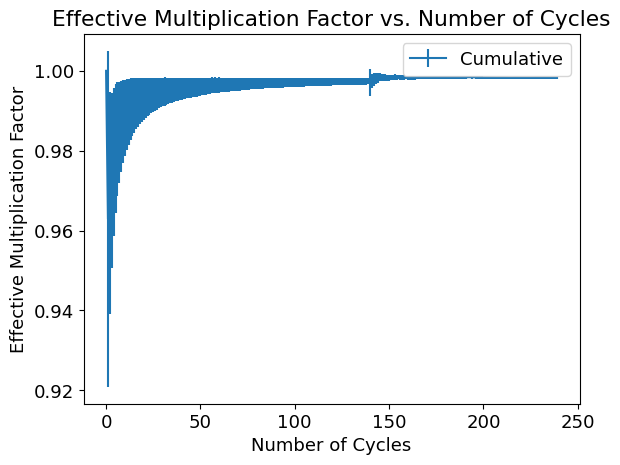

In [100]:
hKeff = hisRes['anaKeff']
hKu = hKeff[:, 2] * 3 * hKeff[:, 1]
cyc = np.arange(hKu.shape[0])
#plt.plot(cyc, hKeff[:, 0], label="Cycle")
plt.title("Effective Multiplication Factor vs. Number of Cycles")
plt.xlabel("Number of Cycles")
plt.ylabel("Effective Multiplication Factor")
plt.errorbar(cyc, hKeff[:, 1], yerr=hKu, label="Cumulative")
plt.legend()

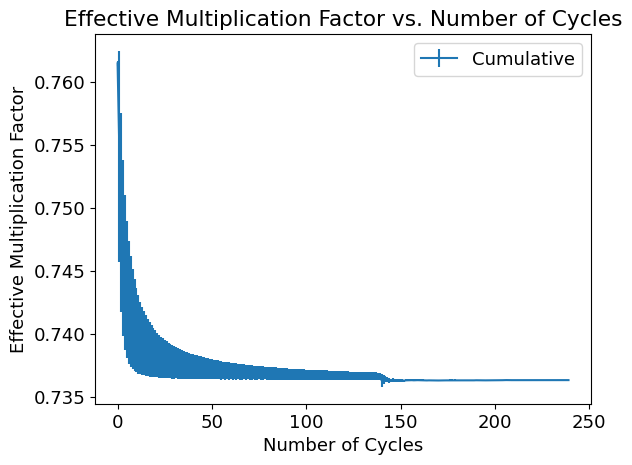

In [101]:
hKeff = hisRes['entrSwg']
hKu = hKeff[:, 2] * 3 * hKeff[:, 1]
cyc = np.arange(hKu.shape[0])
#plt.plot(cyc, hKeff[:, 0], label="Cycle")
plt.title("Effective Multiplication Factor vs. Number of Cycles")
plt.xlabel("Number of Cycles")
plt.ylabel("Effective Multiplication Factor")
plt.errorbar(cyc, hKeff[:, 1], yerr=hKu, label="Cumulative")
plt.legend()

### Radial GCU Resolution Study 2D

####  Make Sure Cases are unbiased torwards statistics on few-group data

In [102]:
maxs = []
max = None
maxunis = []
for uni in ringres.universes:
    maxs.append(np.max(ringres.universes[uni].infUnc['infTot']))
    maxunis.append(uni)
print(maxunis[np.where(maxs == np.max(maxs))[0][0] ], np.max(maxs))

UnivTuple(universe='6900', burnup=0, step=0, days=0) 0.02458


#### Keff Comparison

In [103]:
reffKeff = ringres.resdata['absKeff']
print("Reference Serpent Keff: {:.6}, pcm: {}".format(reffKeff[0],reffKeff[1]*1e5))

Reference Serpent Keff: 0.998287, pcm: 6.0


In [104]:
ringResDF = postProcess('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_out.csv', isSteady=True)

In [105]:
def kToPCM(k):
    return 1e5*((k-1)/k)

In [106]:
griff_rkeff = ringResDF['eigenvalue'][1]

print("ring resolution keff: {:.5f}, pcmDiff: {:.1f}".format(griff_rkeff, kToPCM(griff_rkeff) - kToPCM(reffKeff[0])))

ring resolution keff: 0.99751, pcmDiff: -78.2


In [107]:
kToPCM(griff_rkeff)

-249.76872079748424

In [108]:
kToPCM(reffKeff[0])

-171.5939404199358

In [109]:
171.84 -111

60.84

In [110]:
-216 - - 65.47


-150.53

1. PCM difference decreases with increase in spatial resolution as espected

In [111]:
1.00321

1.00321

#### Verification of Few Group Spectrum

In [112]:
fgs_hr18 = [5.0000E-09, 2.5000E-08, 1.0000E-07, 4.0000E-07, 9.9600E-07, 3.0000E-06,
9.8770E-06, 2.7700E-05, 1.0000E-04, 5.5000E-04, 3.0000E-03, 1.5030E-02,
1.0000E-01, 4.0000E-01, 8.2100E-01, 1.3530E+00, 3.0000E+00, 6.0655E+00,
2.0000E+01]

In [113]:
refFGSFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3.main_det0.m'
refFGSDet = st.read(refFGSFile)
refFGS = refFGSDet['fgsdet']

In [114]:
def normZeroToOne(arr):
    normArr = np.zeros(len(arr))
    min = np.min(arr)
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i] - min)/(max - min)
    return normArr

In [115]:
def normMaximum(arr):
    normArr = np.zeros(len(arr))
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i])/(max)
        
    return normArr

In [116]:
normRefFGS = normMaximum(refFGS.tallies)

In [117]:
# plt.stairs(normRefFGS)

In [118]:
#collectFGS
nFewGroups = 18

griff_ringResFGS = []

for i in range(nFewGroups-1, -1, -1):
    griff_ringResFGS.append(ringResDF['Flux{}'.format(i+1)][1])


normGriff_ringResFGS = normMaximum(griff_ringResFGS)


In [119]:
groupBins = np.linspace(0, 18, 19).astype("int")
print(groupBins)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [120]:
ringRelError = calcPercentRelativeError(normRefFGS, normGriff_ringResFGS)
print(np.max(ringRelError))

7.5689440477669665


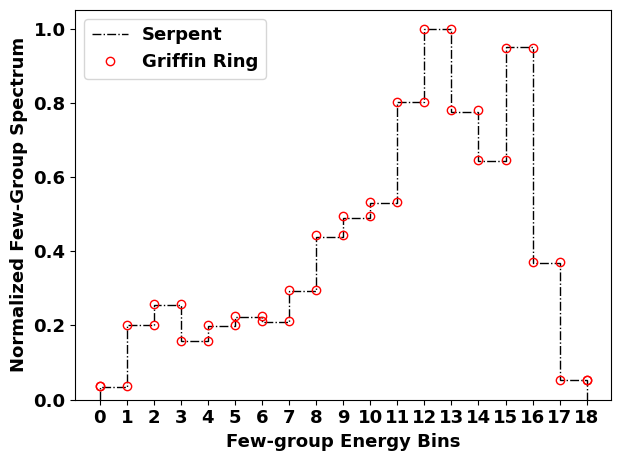

In [151]:

# plt.stairs(normGriff_ringResFGS, groupBins, label = "Griffin_Ring", linewidth = 1, alpha = 1, linestyle = ":")
plt.stairs(normRefFGS, groupBins, label = "Serpent", color = "k", alpha = 1, linewidth = "1", linestyle = "-.")
plt.xticks(groupBins)

plt.plot(np.repeat(groupBins, 2), np.hstack([normGriff_ringResFGS[0], np.repeat(normGriff_ringResFGS, 2), normGriff_ringResFGS[-1]]),
         'o', color='red', alpha=1, label = "Griffin Ring",markerfacecolor='None')
# plt.plot(np.repeat(bins, 2), np.hstack([normGriff_elemResFGS[0], np.repeat(normGriff_elemResFGS, 2), normGriff_elemResFGS[-1]]),
#          '*', color='blue', alpha=0.6, label = "Griffin Element")


plt.xlabel("Few-group Energy Bins")
plt.ylabel("Normalized Few-Group Spectrum")
plt.legend(loc='upper left')
plt.tight_layout()
#plt.grid()

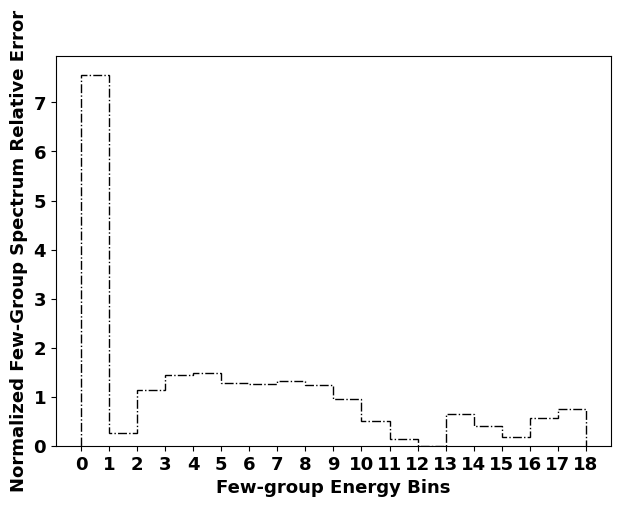

In [152]:
plt.stairs(ringRelError, groupBins, label = "Serpent", color = "k", alpha = 1, linewidth = "1", linestyle = "-.")
plt.xticks(groupBins)
plt.xlabel("Few-group Energy Bins")
plt.ylabel("Normalized Few-Group Spectrum Relative Error")
# plt.legend(loc='upper right')
plt.tight_layout()

In [123]:
def calcL2NormDiffPerc(ref,  comp):
    diff = np.subtract(ref, comp)
    diffNorm  = norm(diff)
    base = norm(ref)
    return (diffNorm/base)*100

def calcPercentRelativeError(ref, comp):
    relErr = []
    diff = np.abs(np.subtract(ref, comp))

    for i in range(0, len(diff)):
        if (diff[i] !=0 ) & (ref[i] !=0) :
            #relErr.append(2*(diff[i]/(np.abs(ref[i])+np.abs(comp[i]))))
            relErr.append(100*diff[i]/ref[i])
        elif (diff[i] == 0):
            maxRef = np.max(ref)
            relErr.append(0)
        else:
            maxRef = np.max(ref)
            relErr.append(100*diff[i]/maxRef)
        #print("diff: {:.2f}, comp: {:.2f}, ref: {:.2f}, relerror: {:.2f}".format(diff[i], comp[i], ref[i], relErr[i]))

    return relErr

In [124]:
ringL2NormDiffFGS = calcL2NormDiffPerc(normRefFGS, normGriff_ringResFGS)

In [125]:
print("ring resolution FGS l2normDiff (%): {:.3f}".format(ringL2NormDiffFGS))

ring resolution FGS l2normDiff (%): 0.576


#### Flux Map Comparison

In [126]:
ringRefMapFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3.main_det0.m'
ringRefMapDet = st.read(ringRefMapFile, reader='det')

In [127]:
def griffinFluxMapReader(path):
    keys = ['volume', 'nufiss', 'power', 'absorption', 'scalar']
    block = []
    vol = []
    nufiss = []
    pow = []
    abs = []
    scalar = []
    with open(path, "r") as f:
        lines = f.readlines()
        f.close()

    bidx = None
    eidx = None
    hasBegun = False
    for ldx, line in enumerate(lines):
        if "Block average" in line:
            bidx = ldx+2
            hasBegun = True 
        if (line == "\n") & hasBegun:
            eidx = ldx
            break
    
    data = lines[bidx:eidx]

    dicts = []

    for i in range(0, len(data)):
        vals  = data[i].split()
        block.append(vals[0])
        vol.append(float(vals[1]))
        nufiss.append(float(vals[2]))
        pow.append(float(vals[3]))
        abs.append(float(vals[4]))
        scalar.append(float(vals[5]))

        dset = [vol[i], nufiss[i], pow[i], abs[i], scalar[i]]
        dicts.append(dict(zip(keys, dset)))


    map = dict(zip(block, dicts))
    return map

In [128]:
ringGriffBlockMap = griffinFluxMapReader('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_flux_map.txt')

In [129]:
ringGriffBlockMap

{'9': {'volume': 1329.057248,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 4.715923e-09,
  'scalar': 0.0009272594},
 '20': {'volume': 651.948459,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 3.411795e-10,
  'scalar': 6.324668e-05},
 '40': {'volume': 716.518434,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 3.455751e-10,
  'scalar': 6.382185e-05},
 '71': {'volume': 36.956005,
  'nufiss': 3.718771e-05,
  'power': 4.952282e-16,
  'absorption': 2.232212e-05,
  'scalar': 0.000680881},
 '72': {'volume': 63.353152,
  'nufiss': 3.635738e-05,
  'power': 4.841761e-16,
  'absorption': 2.182621e-05,
  'scalar': 0.0006646325},
 '73': {'volume': 95.029728,
  'nufiss': 3.510311e-05,
  'power': 4.674761e-16,
  'absorption': 2.107666e-05,
  'scalar': 0.0006396496},
 '74': {'volume': 126.706304,
  'nufiss': 3.331739e-05,
  'power': 4.437016e-16,
  'absorption': 1.999583e-05,
  'scalar': 0.0006053442},
 '75': {'volume': 158.382879,
  'nufiss': 3.124411e-05,
  'power': 4.161059e-16,
  'absorpti

In [130]:
def getBlock2UniMap(df, blockMap):
    uniMap = {}
    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    bkeyu = {}

    for bdx, block in enumerate(blocks):
        bkeyu[block.replace("block_", "")] = str(int(unis[bdx]))
        #print(unis[bdx])

    for block in blockMap:
        uniMap[bkeyu[block]] = blockMap[block]
    
    return uniMap, bkeyu

In [131]:
def getUni2BlockMap(df, uniMap):
    blockMap = {}

    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    ukeyb = {}

    for bdx, block in enumerate(blocks):
        ukeyb[str(int(unis[bdx]))] = block.replace("block_", "")

    for uni in uniMap:
        # uniMap[bkeyu[block]] = blockMap[block]

        blockMap[ukeyb[uni]] = uniMap[str(uni)]
    return blockMap, ukeyb

In [132]:
ringCellData = pd.read_csv('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_cellData.csv')


In [133]:
ringGriffMap, bkeyu = getBlock2UniMap(ringCellData, ringGriffBlockMap)

In [134]:
# print(coreGriffMap)
# print(ringGriffMap)
# print(elemGriffMap)

In [135]:

ringUnis = list(ringGriffMap.keys())

# print(createDetectors(coreUnis))
# print(createDetectors(ringUnis))
# print(createDetectors(elemUnis))

In [136]:
def getUniValsList(map, attr):
    vals = []
    for uni in map:
        vals.append(map[uni][attr])
    return vals

In [137]:
coreNuFissMap = {}
coreCapMap = {}

coreNuFiss = []
coreCap = []

ringNuFissMap = {}
ringCapMap = {}

ringNuFiss = []
ringCap = []

elemNuFissMap = {}
elemCapMap = {}

elemNuFiss = []
elemCap = []



for uni in ringUnis:
    ringNuFissMap[uni] = ringRefMapDet["nuFissRate{}".format(uni)]
    ringCapMap[uni] = ringRefMapDet["scalarFlux{}".format(uni)]



In [138]:

for uni in ringNuFissMap:
    ringNuFiss.append(ringNuFissMap[uni].tallies/ringGriffMap[uni]['volume'])
    ringCap.append(ringCapMap[uni].tallies/ringGriffMap[uni]['volume'])

In [139]:
griffRingNuFiss = getUniValsList(ringGriffMap, 'nufiss')
griffRingScalar = getUniValsList(ringGriffMap, 'scalar')

In [140]:
ringNuFissMap

{'900': <serpentTools.detectors.Detector at 0x7fc05795ff10>,
 '8000': <serpentTools.detectors.Detector at 0x7fc057eecc10>,
 '7500': <serpentTools.detectors.Detector at 0x7fc057ec5250>,
 '2100': <serpentTools.detectors.Detector at 0x7fc057ef1f40>,
 '2200': <serpentTools.detectors.Detector at 0x7fc057ef1f10>,
 '2300': <serpentTools.detectors.Detector at 0x7fc057ef1ee0>,
 '2400': <serpentTools.detectors.Detector at 0x7fc057ef1eb0>,
 '2500': <serpentTools.detectors.Detector at 0x7fc057ef1e80>,
 '2600': <serpentTools.detectors.Detector at 0x7fc057ef1e50>,
 '2700': <serpentTools.detectors.Detector at 0x7fc057ef1e20>,
 '2800': <serpentTools.detectors.Detector at 0x7fc057ef1df0>,
 '3100': <serpentTools.detectors.Detector at 0x7fc057ef1dc0>,
 '1100': <serpentTools.detectors.Detector at 0x7fc05795b700>,
 '1200': <serpentTools.detectors.Detector at 0x7fc05795b7f0>,
 '1300': <serpentTools.detectors.Detector at 0x7fc05795b6d0>,
 '1400': <serpentTools.detectors.Detector at 0x7fc05795b6a0>,
 '1500': 

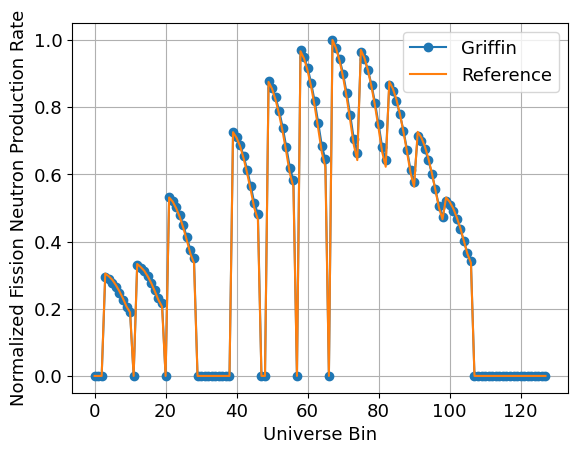

In [141]:
plt.plot(normMaximum(griffRingNuFiss), label = "Griffin", marker = "o")
plt.plot(normMaximum(ringNuFiss), label = "Reference")
plt.ylabel("Normalized Fission Neutron Production Rate")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid()

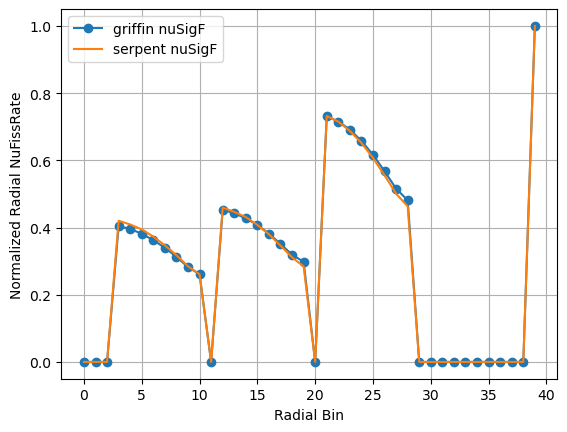

In [75]:
plt.plot(normMaximum(griffRingNuFiss[0:40]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[0:40]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

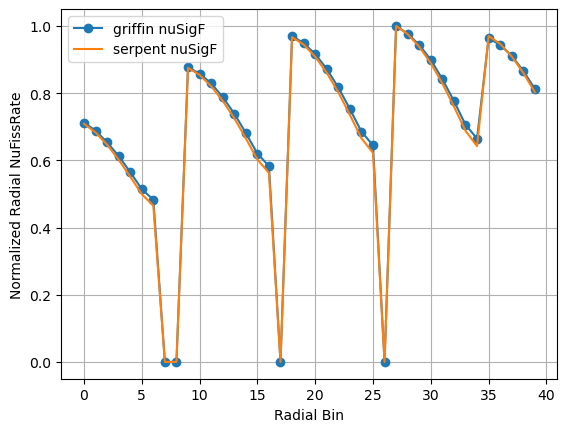

In [76]:
plt.plot(normMaximum(griffRingNuFiss[40:80]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[40:80]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

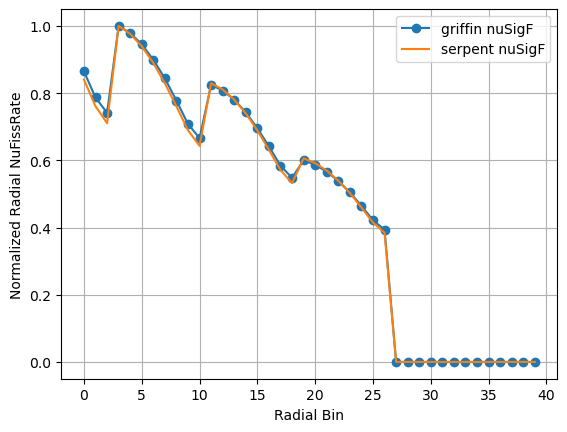

In [77]:
plt.plot(normMaximum(griffRingNuFiss[80:120]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[80:120]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

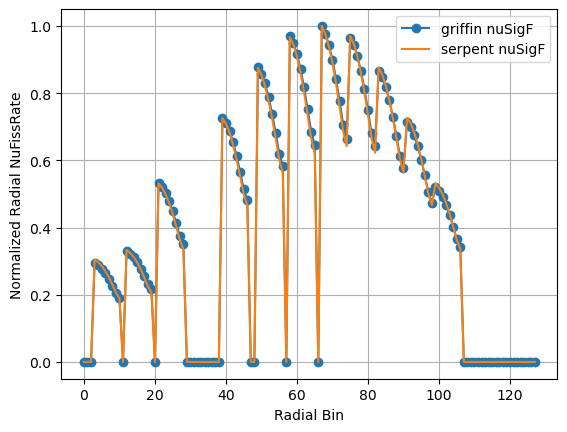

In [78]:
plt.plot(normMaximum(griffRingNuFiss), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

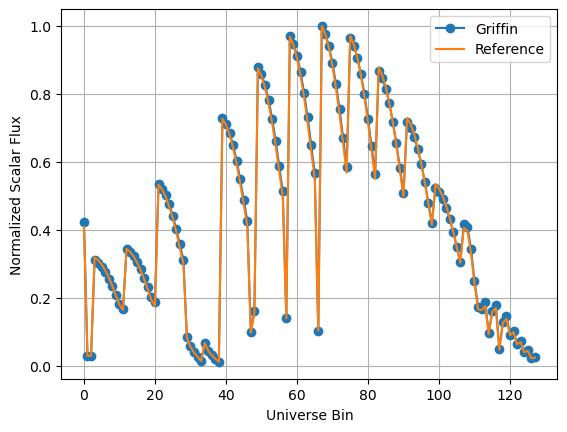

In [79]:
plt.plot(normMaximum(griffRingScalar), label = "Griffin", marker = "o")
plt.plot(normMaximum(ringCap), label = "Reference")
plt.ylabel("Normalized Scalar Flux")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid()

In [80]:
ringL2NormDiffNuFiss = calcL2NormDiffPerc(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
print("ring resolution NuFissRate l2normDiff (%): {:.3f}".format(ringL2NormDiffNuFiss))


ring resolution NuFissRate l2normDiff (%): 1.557


In [81]:
ringL2NormDiffScalar = calcL2NormDiffPerc(normMaximum(ringCap), normMaximum(griffRingScalar))
print("ring resolution ScalarFlux l2normDiff (%): {:.3f}".format(ringL2NormDiffScalar))

ring resolution ScalarFlux l2normDiff (%): 1.546


In [82]:
ringNuFissRateRelError = calcPercentRelativeError(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
ringNuFissRateRelErrorMap = dict(zip(ringUnis, ringNuFissRateRelError))

ringScalarRelError = calcPercentRelativeError(normMaximum(ringCap), normMaximum(griffRingScalar))
ringScalarRelErrorMap = dict(zip(ringUnis, ringScalarRelError))

In [83]:
serpNuFissMap = dict(zip(ringUnis, normMaximum(ringNuFiss)))
griffNuFissMap = dict(zip(ringUnis, normMaximum(griffRingNuFiss)))

serpScalarMap = dict(zip(ringUnis, normMaximum(ringCap)))
griffScalarMap = dict(zip(ringUnis, normMaximum(griffRingScalar)))

In [84]:
errorArr = np.ones(len(ringNuFissRateRelError))*5
highErrorsIdx = np.where(ringScalarRelError > errorArr)[0]

for idx, index in enumerate(highErrorsIdx):
    print(ringUnis[index], ringScalarRelError[index])


2000 6.451809631981553
3500 6.477672498442295
3600 5.470433040472298
5500 5.213028069524892


In [85]:
maxNuFissError = np.max(ringNuFissRateRelError)
maxScalarError = np.max(ringScalarRelError)

In [88]:
print("max nufiss relerr (%): {:.3f}".format(maxNuFissError))
print("max total scalflux relerr (%): {:.3f}".format(maxScalarError))

max nufiss relerr (%): 5.092
max total scalflux relerr (%): 6.478


In [86]:
for uni in ringScalarRelErrorMap:
    if ringScalarRelErrorMap[uni] == maxScalarError:
        print(uni)


3500


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


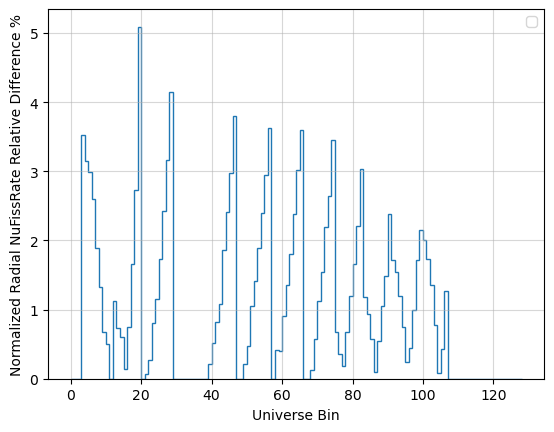

In [66]:
plt.stairs(ringNuFissRateRelError , alpha = 1)
plt.ylabel("Normalized Radial NuFissRate Relative Difference %")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid(alpha = 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


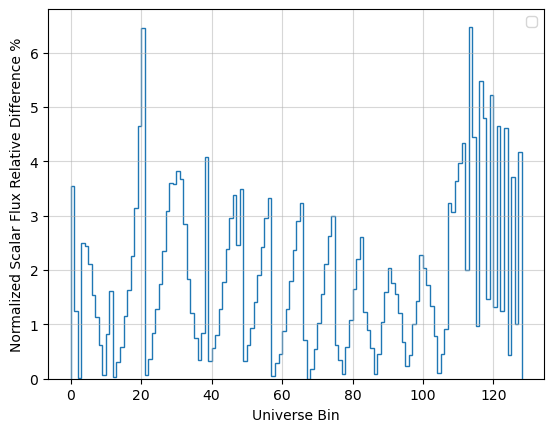

In [67]:
plt.stairs(ringScalarRelError , alpha = 1)
plt.ylabel("Normalized Scalar Flux Relative Difference %")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid(alpha = 0.5)

In [68]:
def createAppendCSV(cellData, keys, params, vals, exportPath, useBlockId = False):
    xyz = ['x', 'y', 'z']

    for param in params:
        xyz.append(param)

    appendDF = pd.DataFrame(columns=xyz)

    map = {}

    for key in keys:
        for pdx, param in enumerate(params):
            map[key] = {}
            
    for kdx, key in enumerate(keys):
        for pdx, param in enumerate(params):
            map[key][param] = vals[pdx][kdx]

    
    if not useBlockId:
        pointKeys = np.array(list(cellData['material_id'])).astype('int')
    else:
        pointKeys = []
        blocks = list(cellData['Block Name'])
        for i in range(0, len(blocks)):
            pointKeys.append(int(blocks[i].replace("block_", "")))

    appendDF['x'] = list(cellData['Points_0'])
    appendDF['y'] = list(cellData['Points_1'])
    appendDF['z'] = list(cellData['Points_2'])

    for param in params:
        pointData = []
        for i in range(0, len(pointKeys)):
            pointData.append(map[str(pointKeys[i])][param])
        
        appendDF[param] = pointData

    appendDF.to_csv(exportPath, index=False)
    
    return appendDF

In [69]:
def createAppendCSVNEW(keys, maps, path):
    keys.append("matid")  
    appendDF = pd.DataFrame(columns= keys)


    for kdx, key in enumerate(keys):
        temp = []
        for matId in maps[0]:
            if key == "matid":
                #print(matId)
                temp.append(matId)
            else:
                #print(maps[kdx][matId])
                temp.append(maps[kdx][matId])
        appendDF[key] = temp
            
    appendDF.to_csv(path, index=False)
    return appendDF

In [70]:
cellDataPath = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c3_cellDataAppend.csv'
keys = ['norm_RefnuFissRate', 'norm_griffnuFissRate', 'nuFissRateRelError', 'norm_RefscalarFlux', 'norm_griffscalarFlux', 'scalarFluxRelError']
maps = [serpNuFissMap, griffNuFissMap, ringNuFissRateRelErrorMap, serpScalarMap, griffScalarMap, ringScalarRelErrorMap]
createAppendCSVNEW(keys, maps, cellDataPath)

,norm_RefnuFissRate,norm_griffnuFissRate,nuFissRateRelError,norm_RefscalarFlux,norm_griffscalarFlux,scalarFluxRelError,matid
0,0.00000,0.00000,0.00000,0.40826,0.42274,3.54736,900
1,0.00000,0.00000,0.00000,0.02848,0.02883,1.25527,8000
2,0.00000,0.00000,0.00000,0.02909,0.02910,0.02224,7500
3,0.30476,0.29400,3.52786,0.31836,0.31042,2.49546,2100
4,0.29678,0.28744,3.14607,0.31060,0.30301,2.44512,2200
...,...,...,...,...,...,...,...
123,0.00000,0.00000,0.00000,0.06899,0.07218,4.62246,5700
124,0.00000,0.00000,0.00000,0.03956,0.03973,0.43878,6300
125,0.00000,0.00000,0.00000,0.04340,0.04501,3.71101,5800
126,0.00000,0.00000,0.00000,0.02147,0.02169,1.01447,6400
